# Retina MNIST notebook

## import libraries

In [14]:
import os
# Set TensorFlow logging to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # This silences INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
tf.get_logger().setLevel('ERROR')

try:
  import pennylane as qml
except:
  !pip install pennylane
  import pennylane as qml
from pennylane.operation import Operation

## Import the dataset

In [15]:
# !pip install medmnist

In [16]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
import random as rd


In [17]:
def download_and_prepare_dataset(data_info: dict):
    """Utility function to download the dataset.

    Arguments:
        data_info (dict): Dataset metadata.
    """
    data_path = tf.keras.utils.get_file(origin=data_info["url"], md5_hash=data_info["MD5"])

    with np.load(data_path) as data:
        # Get videos
        train_videos = data["train_images"]
        valid_videos = data["val_images"]
        test_videos = data["test_images"]

        # Get labels
        train_labels = data["train_labels"].flatten()
        valid_labels = data["val_labels"].flatten()
        test_labels = data["test_labels"].flatten()

    return (
        (train_videos, train_labels),
        (valid_videos, valid_labels),
        (test_videos, test_labels),
    )


# Get the metadata of the dataset
info = medmnist.INFO["retinamnist"]
# info = medmnist.INFO["retinamnist"]


# Get the dataset
prepared_dataset = download_and_prepare_dataset(info)
(x_train, y_train) = prepared_dataset[0]
(x_val, y_val) = prepared_dataset[1]
(x_test, y_test) = prepared_dataset[2]

In [18]:
import numpy as np
from sklearn.decomposition import PCA
from tensorflow.keras.utils import to_categorical
x_train = x_train/255
x_test = x_test/255

# Expand the dimensions of the images to (28, 28, 1) to represent the grayscale channel explicitly
train_images = np.expand_dims(x_train, -1)
test_images = np.expand_dims(x_test, -1)

# Flatten the images to 2D arrays for PCA
train_images_flat = train_images.reshape(train_images.shape[0], -1)  # Shape: (num_samples, 28*28)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

# Initialize PCA to keep 8 components
pca = PCA(n_components=8)

# Fit PCA on the training images and transform the datasets
train_images = pca.fit_transform(train_images_flat)
test_images = pca.transform(test_images_flat)

# Map the labels 3 -> 0 and 6 -> 1
y_train = np.where(y_train == 0, 0, 1)
y_test = np.where(y_test == 0, 0, 1)

# One-hot encode the labels
train_labels = to_categorical(y_train, 2)
test_labels = to_categorical(y_test, 2)

# Print the shapes of the processed datasets
print("Shape of train images after PCA:", train_labels.shape)
print("Shape of test images after PCA:", test_labels.shape)
print("Shape of train labels:", train_labels.shape)
print("Shape of test labels:", test_labels.shape)


Shape of train images after PCA: (1080, 2)
Shape of test images after PCA: (400, 2)
Shape of train labels: (1080, 2)
Shape of test labels: (400, 2)


In [19]:
unique_labels = np.unique(y_train)
print(f"Unique labels in the training set: {unique_labels}")

Unique labels in the training set: [0 1]


In [20]:
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    grid_size = 5
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

In [21]:
def plot_learning_curve(history):
    # Extracting training and validation accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Extracting training and validation loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting the accuracy
    plt.figure(figsize=(12, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()


## Common Quantum functions

In [22]:
class RBSGate(Operation):
    num_params = 1
    num_wires = 2
    par_domain = 'R'

    def __init__(self, theta, wires):
        super().__init__(theta, wires=wires)
        self.theta = theta

    @staticmethod
    def compute_matrix(theta):
        cos = tf.cos(theta)
        sin = tf.sin(theta)
        return tf.convert_to_tensor([
            [1, 0, 0, 0],
            [0, cos, sin, 0],
            [0, -sin, cos, 0],
            [0, 0, 0, 1]
        ], dtype=tf.float64)

    def adjoint(self):
        return RBSGate(-self.parameters[0], wires=self.wires)

    def label(self, decimals=None, base_label=None, **kwargs):
        theta = self.parameters[0]
        return f"RBS({theta:.2f})"
def convert_array(X):
    alphas = tf.zeros(X.shape[:-1] + (X.shape[-1]-1,), dtype=X.dtype)
    X_normd = tf.linalg.l2_normalize(X, axis=-1)
    for i in range(X.shape[-1]-1):
        prod_sin_alphas = tf.reduce_prod(tf.sin(alphas[..., :i]), axis=-1)
        updated_value = tf.acos(X_normd[..., i] / prod_sin_alphas)
        indices = tf.constant([[i]])
        updates = tf.reshape(updated_value, [1])
        alphas = tf.tensor_scatter_nd_update(alphas, indices, updates)
    return alphas
def vector_loader(alphas, wires=None, is_x=True, is_conjugate=False):
    if wires is None:
        wires = list(range(len(alphas) + 1))
    if is_x and not is_conjugate:
        qml.PauliX(wires=wires[0])
    if is_conjugate:
        for i in range(len(wires) - 2, -1, -1):
            qml.apply(RBSGate(-alphas[i], wires=[wires[i], wires[i+1]]))
    else:
        for i in range(len(wires) - 1):
            qml.apply(RBSGate(alphas[i], wires=[wires[i], wires[i+1]]))
    if is_x and is_conjugate:
        qml.PauliX(wires=wires[0])
def pyramid_circuit(parameters, wires=None):
    if wires is None:
        length = len(qml.device.wires)
    else:
        length = len(wires)

    k = 0

    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)

        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1

# qOrthNN + Gradient Pruning

In [23]:
import math

# Define a step counter
global_step = tf.Variable(0, dtype=tf.int64, trainable=False)

# Define a custom callback
class StepCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        global_step.assign(0)
    def on_train_batch_end(self, batch, logs=None):
        global_step.assign_add(1)
        current_step = global_step.numpy()
        if current_step % 5 == 0:
            # Increase the pruning ratio
            current_prune_ratio = self.model.prune_ratio
            # Increase prune_ratio by multiplying with exp(0.1)
            new_prune_ratio = min(current_prune_ratio * math.exp(0.1), 1.0)  # Cap at 1.0
            self.model.prune_ratio = new_prune_ratio
    # def on_epoch_begin(self, epoch, logs=None):
    #     tf.print("Updated prune_ratio to", self.model.prune_ratio)

In [24]:
class HybridModel(tf.keras.Model):
    def __init__(self,random1):
        super(HybridModel, self).__init__()
        
        rd.seed(random1)
        np.random.seed(random1)
        tf.random.set_seed(random1)
        qml.numpy.random.seed(random1)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(6, activation='linear', dtype=tf.float64)
        self.quantum_weights = self.add_weight(
            shape=(15,),
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01),
            trainable=True,
            dtype=tf.float32
        )
        self.dev = qml.device('default.qubit.tf', wires=6)
        # Pruning attributes
        self.accumulated_grads = tf.Variable(tf.zeros_like(self.quantum_weights), trainable=False)
        self.accumulate_flag = tf.Variable(True, trainable=False)
        
        self.accumulate_window = tf.constant(10)
        self.prune_window = tf.constant(8)
        self.prune_ratio = tf.constant(0.8)
        
        self.accumulate_count = tf.Variable(6, dtype=tf.int32, trainable=False)
        self.prune_count = tf.Variable(6, dtype=tf.int32, trainable=False)


        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(6))
            pyramid_circuit(weights, wires=range(6))
            return [qml.expval(qml.PauliZ(wire)) for wire in range(6)]

        self.quantum_circuit = quantum_circuit
        self.classical_nn_2 = tf.keras.layers.Dense(2, activation='sigmoid', dtype=tf.float64)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        flattened_inputs = self.flatten(inputs)
        classical_output = self.dense(flattened_inputs)
        quantum_outputs = tf.map_fn(
            lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights)),
            classical_output,
            fn_output_signature=tf.TensorSpec(shape=(6,), dtype=tf.float64)
        )
        # Handle NaN values in quantum outputs
        quantum_outputs = tf.where(tf.math.is_nan(quantum_outputs), tf.zeros_like(quantum_outputs), quantum_outputs)

        # Combine and process quantum outputs through additional NN layers
        quantum_outputs = tf.reshape(quantum_outputs, [-1, 6])
        nn_output = self.classical_nn_2(quantum_outputs)

        return nn_output
    
    @tf.function
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Index of quantum_weights in trainable_variables
        quantum_weights_idx = 0
        
        # switch flag for PGP
        @tf.function
        def switch_flag():
            if self.accumulate_count == 0:
                self.accumulate_count.assign(self.accumulate_window)
                self.accumulate_flag.assign(False)
            elif self.prune_count == 0:
                self.prune_count.assign(self.prune_window)
                self.accumulate_flag.assign(True)
        switch_flag()
        
        # Probabilistic Gradient Pruning
        if tf.equal(self.accumulate_flag, True):
            # Step 1: Accumulate gradients for quantum_weights
            # tf.print("Accu phase:", self.accumulate_count)
            self.accumulate_count.assign_sub(1)
            if gradients[quantum_weights_idx] is not None:
                self.accumulated_grads.assign_add(gradients[quantum_weights_idx])

            # Apply gradients for other variables (excluding quantum_weights)
            # other_gradients = []
            # other_variables = []
            # for i, (grad, var) in enumerate(zip(gradients, self.trainable_variables)):
            #     if i != quantum_weights_idx and grad is not None:
            #         other_gradients.append(grad)
            #         other_variables.append(var)
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        else:
            # Step 2: Prune weights of quantum_weights
            # tf.print("Pruning phase:",self.prune_count)
            self.prune_count.assign_sub(1)
            # Normalize the accumulated gradients
            grad_min = tf.reduce_min(self.accumulated_grads)
            grad_max = tf.reduce_max(self.accumulated_grads)
            epsilon = 1e-8
            norm_grads = (self.accumulated_grads - grad_min) / (grad_max - grad_min + epsilon)

            # Add epsilon to norm_grads to avoid log(0)
            norm_grads_with_epsilon = norm_grads + epsilon

            # Compute logits for categorical sampling
            logits = tf.math.log(norm_grads_with_epsilon)

            # Determine the number of parameters to sample
            num_params = self.quantum_weights.shape[0]
            num_samples = int(self.prune_ratio * num_params)
            num_samples = tf.maximum(1, num_samples) # Ensure at least one parameter is sampled

            # Sample indices based on the normalized gradients
            indices = tf.random.categorical([logits], num_samples=num_samples)
            indices = tf.clip_by_value(indices, 0, self.quantum_weights.shape[0] - 1)  # Ensure indices are within range

            # Create a boolean mask to select the parameters to keep
            mask = tf.zeros_like(self.quantum_weights, dtype=tf.bool)
            indices = tf.cast(indices, tf.int32)
            indices = tf.reshape(indices, [-1, 1])  # Ensure indices are shaped correctly
            updates = tf.ones([tf.shape(indices)[0]], dtype=tf.bool)  # Create updates matching the indices length

            mask = tf.tensor_scatter_nd_update(mask, indices, updates)

            # Apply the mask to the accumulated gradients
            pruned_grad = tf.where(mask, self.accumulated_grads[0], tf.zeros_like(self.accumulated_grads[0]))

            # Apply the pruned gradient to quantum_weights
            self.optimizer.apply_gradients([(pruned_grad, self.quantum_weights)])

            # Apply gradients for other variables (excluding quantum_weights)
            other_gradients = []
            other_variables = []
            for i, (grad, var) in enumerate(zip(gradients, self.trainable_variables)):
                if i != quantum_weights_idx and grad is not None:
                    other_gradients.append(grad)
                    other_variables.append(var)
            self.optimizer.apply_gradients(zip(other_gradients, other_variables))

            # Reset accumulator and accumulate window
            self.accumulated_grads.assign(tf.zeros_like(self.accumulated_grads))

        # Sanitize weights: replace NaNs with zeros
        for var in self.trainable_variables:
            # Create a mask where NaNs are present
            nan_mask = tf.math.is_nan(var)
            # Replace NaNs with zeros
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            # Assign the sanitized variable back to the model
            var.assign(sanitized_var)

        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)
        # tf.print(self.quantum_weights)
        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}

# Plot the training and validation loss

Training with random seed: 10
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.4815 - auc: 0.4785 - loss: 0.6650 - val_accuracy: 0.5850 - val_auc: 0.5858 - val_loss: 0.6805
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6302 - auc: 0.6500 - loss: 0.5237 - val_accuracy: 0.6750 - val_auc: 0.6966 - val_loss: 0.6382
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6867 - auc: 0.7370 - loss: 0.4937 - val_accuracy: 0.7125 - val_auc: 0.7554 - val_loss: 0.5928
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7236 - auc: 0.7795 - loss: 0.4891 - val_accuracy: 0.7450 - val_auc: 0.7688 - val_loss: 0.5671
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7509 - auc: 0.7910 - loss: 0.4980 - val_accuracy: 0.7550 - val_auc: 0.7749 - val_loss: 0.5584
Epoch 6/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7600 - auc: 0.8001 - loss: 0.5022 - val_accuracy: 0.7575 - val_auc: 0.7795 - val_loss: 0.5538
Epo

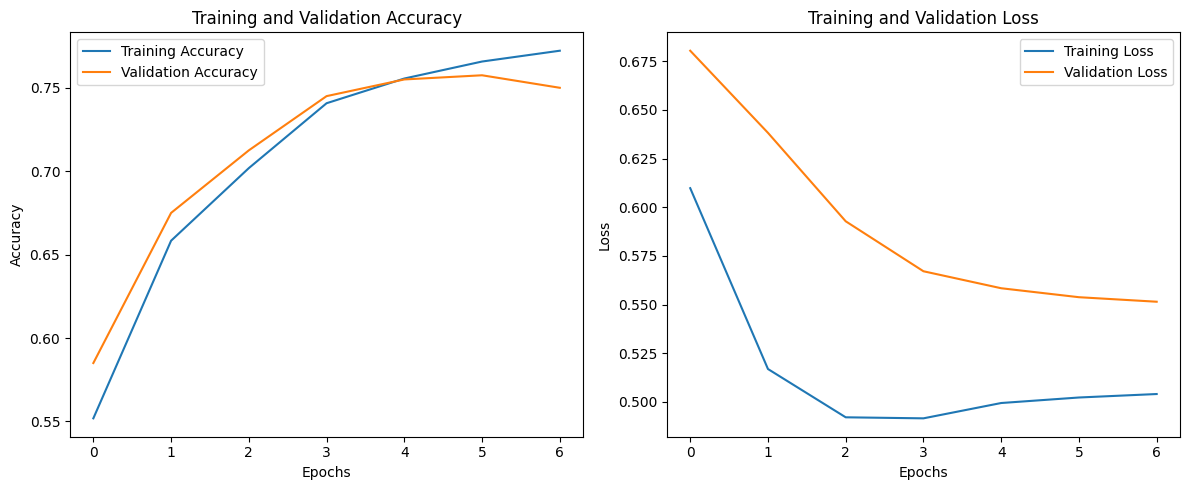

Training with random seed: 20
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.5408 - auc: 0.5661 - loss: 0.5450 - val_accuracy: 0.6900 - val_auc: 0.7318 - val_loss: 0.6191
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7224 - auc: 0.7657 - loss: 0.5146 - val_accuracy: 0.7450 - val_auc: 0.7787 - val_loss: 0.5766
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6734 - auc: 0.6749 - loss: 0.5022 - val_accuracy: 0.5650 - val_auc: 0.5650 - val_loss: 0.6852
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5351 - auc: 0.5262 - loss: 0.5000 - val_accuracy: 0.5650 - val_auc: 0.5650 - val_loss: 0.6848
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6819 - auc: 0.7044 - loss: 0.6342
Test Loss: 0.6190528869628906
Test Accuracy: 0.6899999976158142
Test AUC: 0.7318187355995178


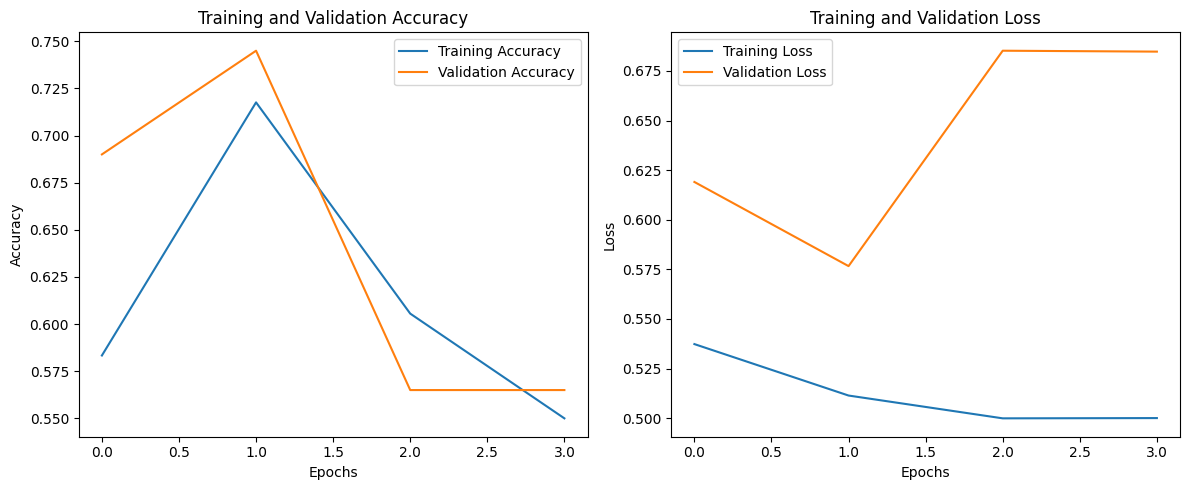

Training with random seed: 30
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.6215 - auc: 0.6303 - loss: 0.6328 - val_accuracy: 0.6550 - val_auc: 0.7314 - val_loss: 0.6124
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6787 - auc: 0.7247 - loss: 0.5206 - val_accuracy: 0.6700 - val_auc: 0.7498 - val_loss: 0.5968
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6904 - auc: 0.7395 - loss: 0.5043 - val_accuracy: 0.6800 - val_auc: 0.7604 - val_loss: 0.5875
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6943 - auc: 0.7508 - loss: 0.5016 - val_accuracy: 0.6875 - val_auc: 0.7679 - val_loss: 0.5817
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6209 - auc: 0.7143 - loss: 0.6227
Test Loss: 0.6124363541603088
Test Accuracy: 0.6549999713897705
Test AUC: 0.7313843965530396


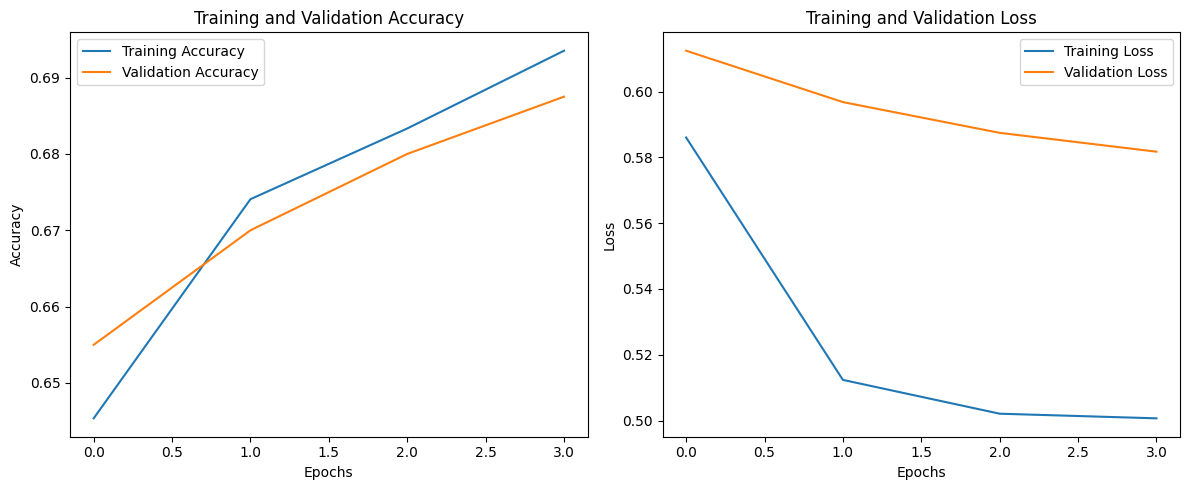

Training with random seed: 40
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.5860 - auc: 0.5621 - loss: 0.4777 - val_accuracy: 0.6025 - val_auc: 0.6313 - val_loss: 0.6703
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6581 - auc: 0.6742 - loss: 0.4949 - val_accuracy: 0.6300 - val_auc: 0.6475 - val_loss: 0.6606
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6470 - auc: 0.6808 - loss: 0.4974 - val_accuracy: 0.5650 - val_auc: 0.5650 - val_loss: 0.6862
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5268 - auc: 0.4952 - loss: 0.5012 - val_accuracy: 0.5650 - val_auc: 0.5650 - val_loss: 0.6850
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5582 - auc: 0.5923 - loss: 0.6861
Test Loss: 0.6702607870101929
Test Accuracy: 0.6025000214576721
Test AUC: 0.6312906742095947


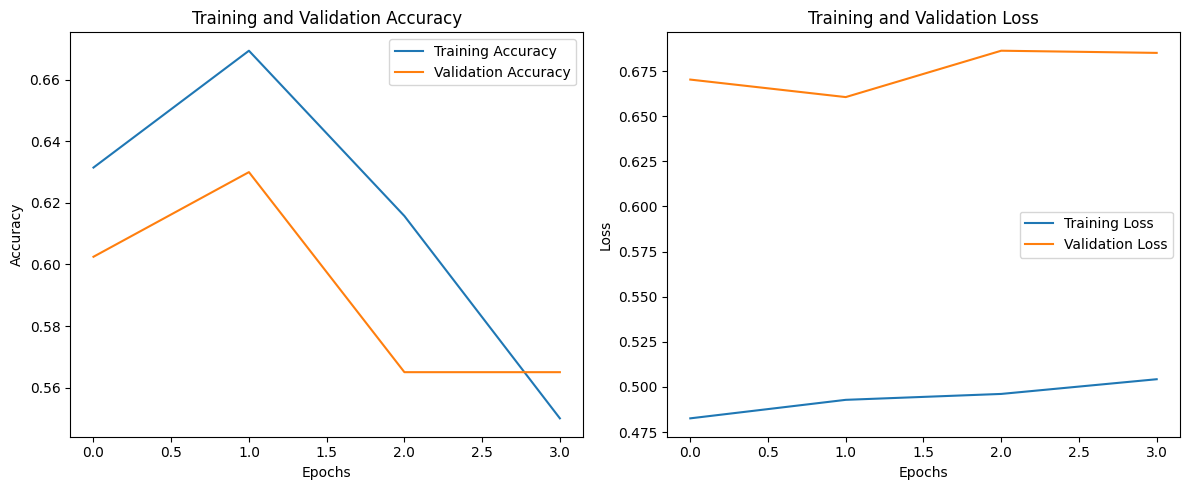

Training with random seed: 50
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 33s 20ms/step - accuracy: 0.4855 - auc: 0.5175 - loss: 0.3444 - val_accuracy: 0.5800 - val_auc: 0.5908 - val_loss: 0.6910
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6717 - auc: 0.6854 - loss: 0.4697 - val_accuracy: 0.6525 - val_auc: 0.6831 - val_loss: 0.6458
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7084 - auc: 0.7484 - loss: 0.4953 - val_accuracy: 0.6950 - val_auc: 0.7301 - val_loss: 0.6150
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7152 - auc: 0.7770 - loss: 0.5009 - val_accuracy: 0.7100 - val_auc: 0.7549 - val_loss: 0.5945
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5779 - auc: 0.5871 - loss: 0.6897
Test Loss: 0.6910324692726135
Test Accuracy: 0.5799999833106995
Test AUC: 0.590778112411499


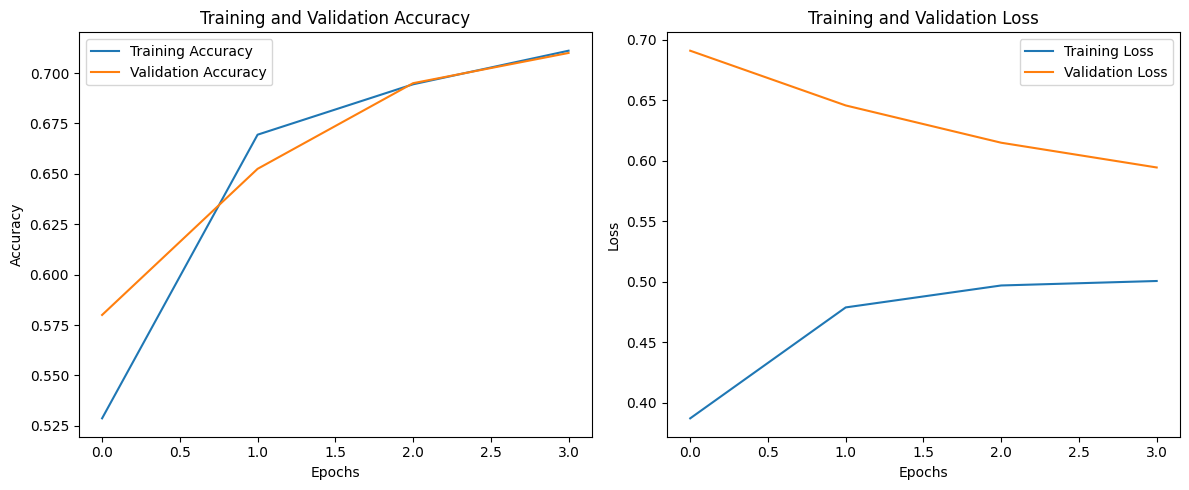

Training with random seed: 60
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.4719 - auc: 0.4860 - loss: 0.4224 - val_accuracy: 0.6350 - val_auc: 0.6485 - val_loss: 0.6631
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6581 - auc: 0.6993 - loss: 0.4880 - val_accuracy: 0.5650 - val_auc: 0.5650 - val_loss: 0.6901
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5673 - auc: 0.5605 - loss: 0.4915 - val_accuracy: 0.5650 - val_auc: 0.5650 - val_loss: 0.6853
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5673 - auc: 0.5546 - loss: 0.4966 - val_accuracy: 0.5650 - val_auc: 0.5650 - val_loss: 0.6847
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6005 - auc: 0.6173 - loss: 0.6744
Test Loss: 0.6630800366401672
Test Accuracy: 0.6349999904632568
Test AUC: 0.6485062837600708


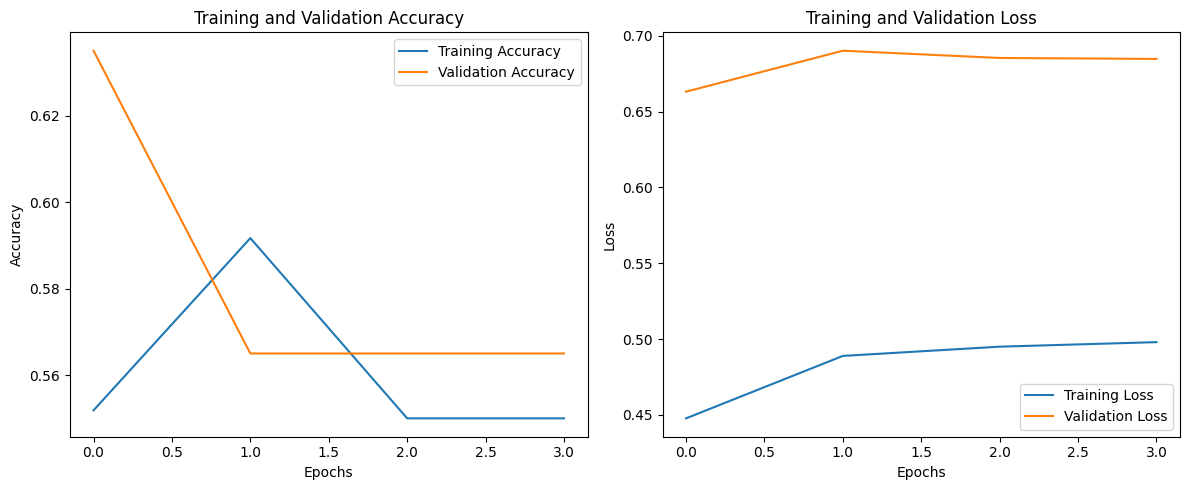

Training with random seed: 70
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.4762 - auc: 0.4754 - loss: 0.5440 - val_accuracy: 0.5975 - val_auc: 0.6063 - val_loss: 0.6802
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6278 - auc: 0.6361 - loss: 0.4969 - val_accuracy: 0.6775 - val_auc: 0.7323 - val_loss: 0.6182
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6813 - auc: 0.7288 - loss: 0.4896 - val_accuracy: 0.7175 - val_auc: 0.7720 - val_loss: 0.5886
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7211 - auc: 0.7684 - loss: 0.4955 - val_accuracy: 0.7425 - val_auc: 0.7841 - val_loss: 0.5731
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7226 - auc: 0.7818 - loss: 0.4968 - val_accuracy: 0.7275 - val_auc: 0.7846 - val_loss: 0.5691
Epoch 6/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7319 - auc: 0.7959 - loss: 0.4967 - val_accuracy: 0.7375 - val_auc: 0.7871 - val_loss: 0.5649
Epoc

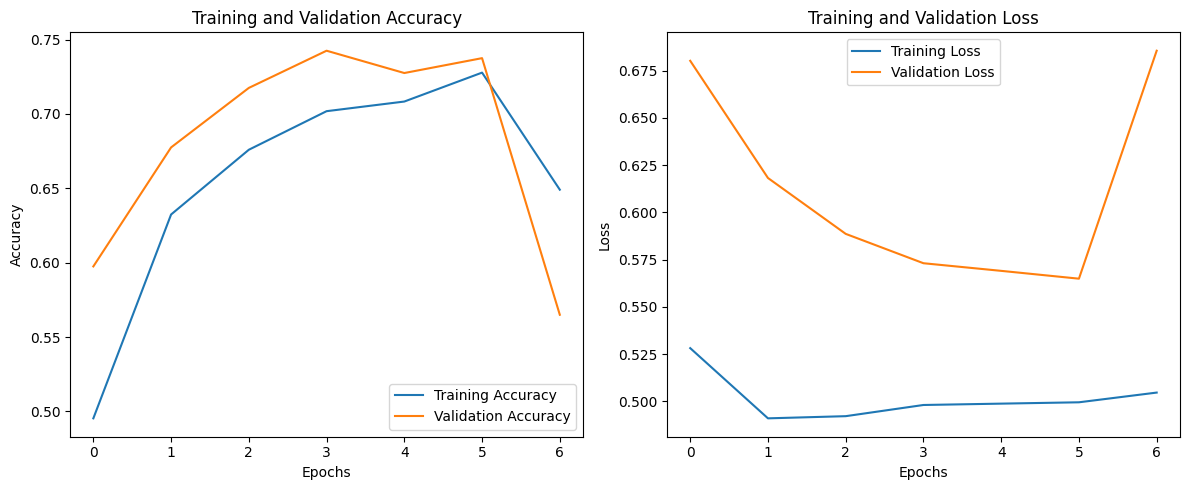

Training with random seed: 80
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.5348 - auc: 0.5468 - loss: 0.4872 - val_accuracy: 0.6600 - val_auc: 0.7227 - val_loss: 0.6415
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6507 - auc: 0.7064 - loss: 0.4942 - val_accuracy: 0.7125 - val_auc: 0.7689 - val_loss: 0.5975
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6736 - auc: 0.7525 - loss: 0.4975 - val_accuracy: 0.7325 - val_auc: 0.7799 - val_loss: 0.5763
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7014 - auc: 0.7730 - loss: 0.4980 - val_accuracy: 0.7375 - val_auc: 0.7836 - val_loss: 0.5648
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6601 - auc: 0.7207 - loss: 0.6433
Test Loss: 0.6415489315986633
Test Accuracy: 0.6600000262260437
Test AUC: 0.7227312326431274


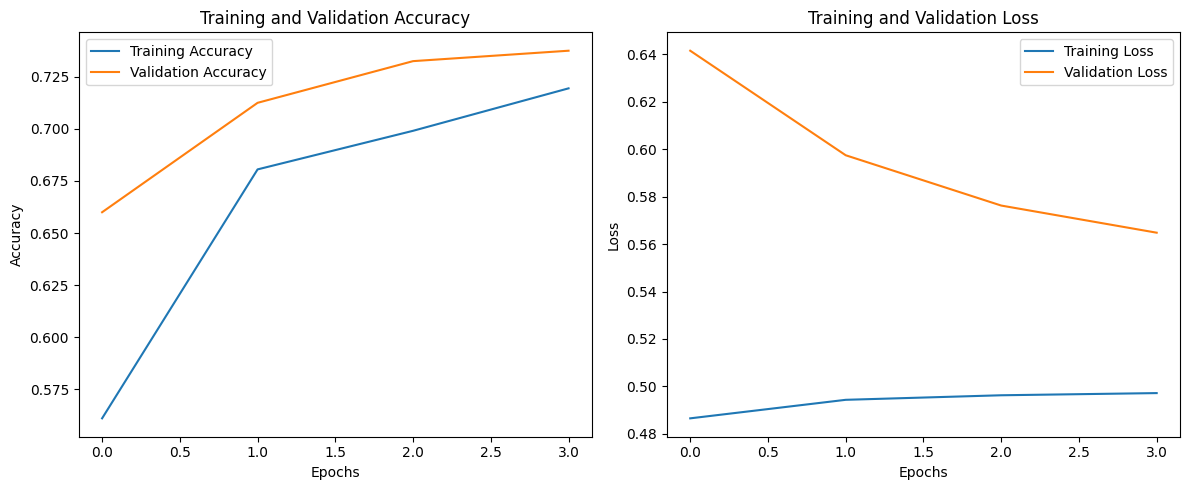

Training with random seed: 90
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 33s 15ms/step - accuracy: 0.5677 - auc: 0.5809 - loss: 0.3639 - val_accuracy: 0.6275 - val_auc: 0.6521 - val_loss: 0.6612
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6697 - auc: 0.6895 - loss: 0.4754 - val_accuracy: 0.6175 - val_auc: 0.6676 - val_loss: 0.6516
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6684 - auc: 0.7213 - loss: 0.4970 - val_accuracy: 0.6500 - val_auc: 0.6863 - val_loss: 0.6404
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6801 - auc: 0.7492 - loss: 0.5012 - val_accuracy: 0.6600 - val_auc: 0.6979 - val_loss: 0.6339
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5760 - auc: 0.5899 - loss: 0.6944
Test Loss: 0.6611897945404053
Test Accuracy: 0.6274999976158142
Test AUC: 0.6521062254905701


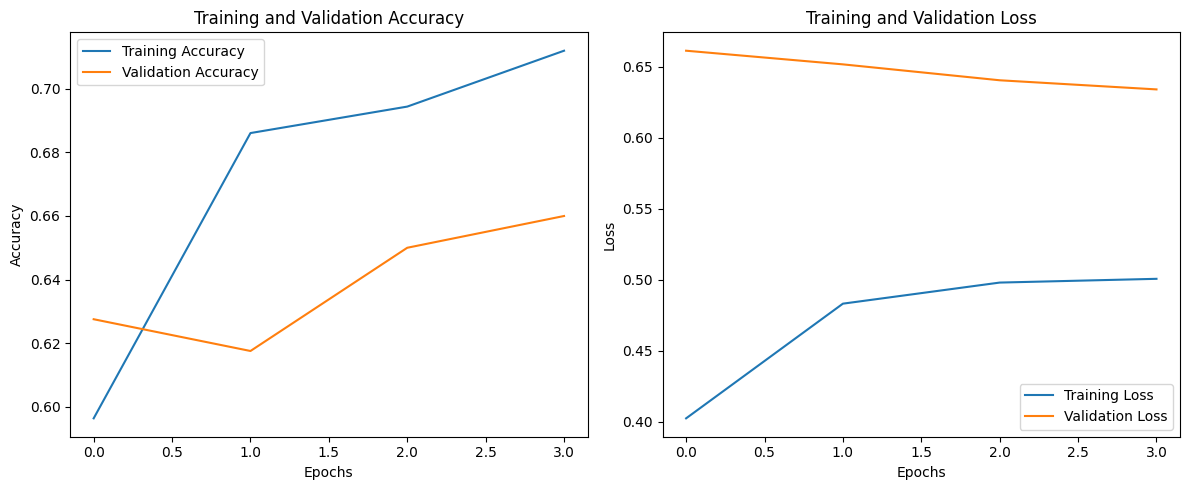

Training with random seed: 100
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.5410 - auc: 0.5437 - loss: 0.4540 - val_accuracy: 0.4350 - val_auc: 0.4350 - val_loss: 0.6996
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5191 - auc: 0.5049 - loss: 0.4976 - val_accuracy: 0.4350 - val_auc: 0.4350 - val_loss: 0.6974
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5233 - auc: 0.5094 - loss: 0.5063 - val_accuracy: 0.4350 - val_auc: 0.4350 - val_loss: 0.6941
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5298 - auc: 0.5257 - loss: 0.5052 - val_accuracy: 0.5650 - val_auc: 0.5650 - val_loss: 0.6907
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.4695 - auc: 0.4695 - loss: 0.6967
Test Loss: 0.6996024250984192
Test Accuracy: 0.4350000023841858
Test AUC: 0.4349999725818634


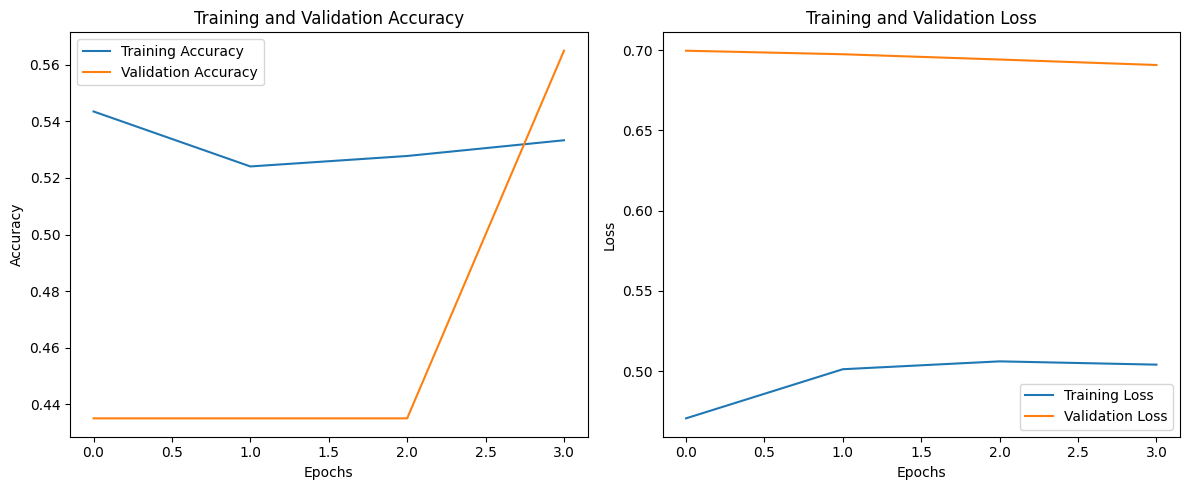

Training with random seed: 110
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.5787 - auc: 0.5586 - loss: 0.5494 - val_accuracy: 0.5600 - val_auc: 0.5425 - val_loss: 0.7041
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6150 - auc: 0.6086 - loss: 0.5129 - val_accuracy: 0.6150 - val_auc: 0.6364 - val_loss: 0.6648
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6753 - auc: 0.6923 - loss: 0.5100 - val_accuracy: 0.6150 - val_auc: 0.6635 - val_loss: 0.6530
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6892 - auc: 0.7375 - loss: 0.5005 - val_accuracy: 0.6400 - val_auc: 0.6765 - val_loss: 0.6454
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5382 - auc: 0.5267 - loss: 0.7096
Test Loss: 0.7040651440620422
Test Accuracy: 0.5600000023841858
Test AUC: 0.5425000190734863


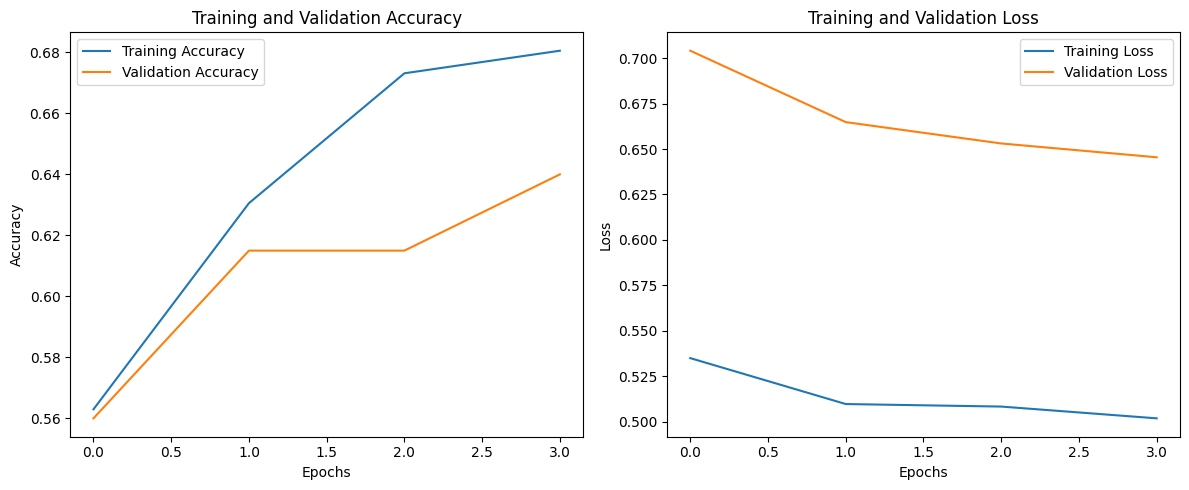

Training with random seed: 120
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.4356 - auc: 0.4238 - loss: 0.3671 - val_accuracy: 0.5600 - val_auc: 0.5580 - val_loss: 0.6943
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5432 - auc: 0.5661 - loss: 0.4821 - val_accuracy: 0.6100 - val_auc: 0.6188 - val_loss: 0.6726
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6016 - auc: 0.6414 - loss: 0.4924 - val_accuracy: 0.6425 - val_auc: 0.6718 - val_loss: 0.6499
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6920 - auc: 0.7078 - loss: 0.4937 - val_accuracy: 0.7125 - val_auc: 0.7317 - val_loss: 0.6164
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5650 - auc: 0.5508 - loss: 0.6940
Test Loss: 0.6942569017410278
Test Accuracy: 0.5600000023841858
Test AUC: 0.558037519454956


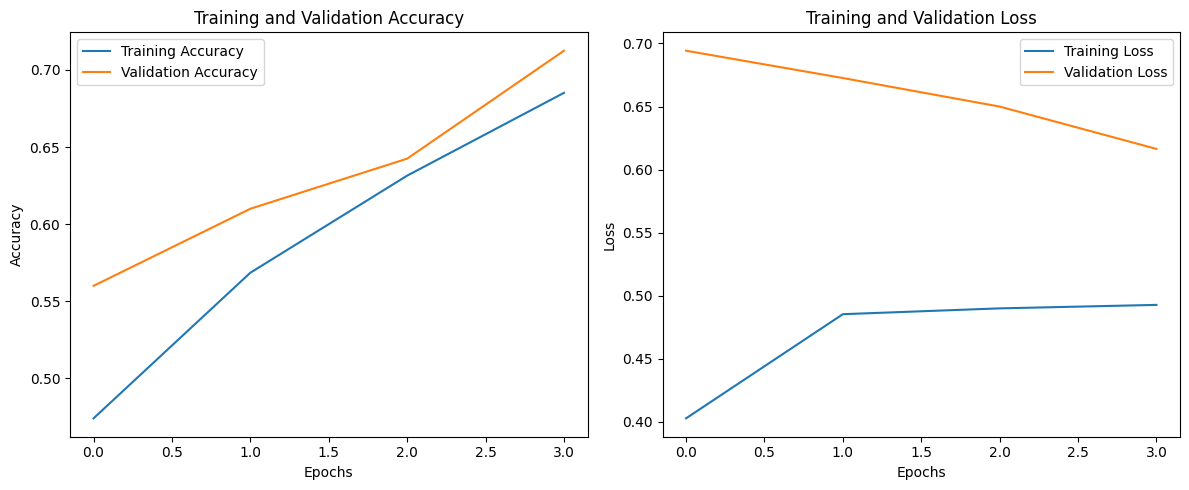

Training with random seed: 130
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - accuracy: 0.5211 - auc: 0.5055 - loss: 0.4881 - val_accuracy: 0.5650 - val_auc: 0.5904 - val_loss: 0.6803
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.5279 - auc: 0.5581 - loss: 0.4969 - val_accuracy: 0.6200 - val_auc: 0.6740 - val_loss: 0.6460
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6295 - auc: 0.6786 - loss: 0.4985 - val_accuracy: 0.6800 - val_auc: 0.7379 - val_loss: 0.6066
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6866 - auc: 0.7281 - loss: 0.4994 - val_accuracy: 0.6950 - val_auc: 0.7501 - val_loss: 0.5938
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5305 - auc: 0.5466 - loss: 0.6995
Test Loss: 0.6803216338157654
Test Accuracy: 0.5649999976158142
Test AUC: 0.5904437303543091


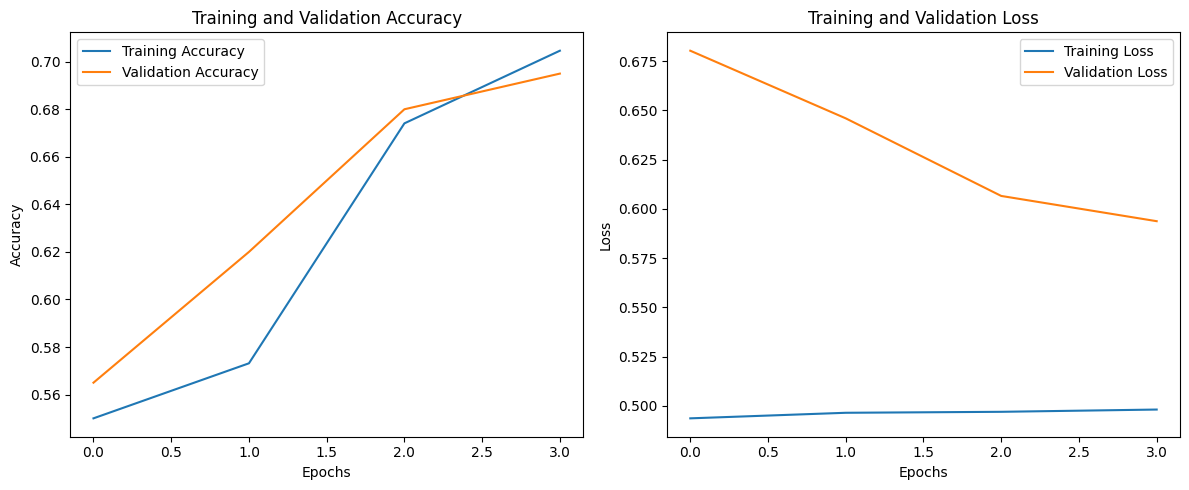

Training with random seed: 140
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.5804 - auc: 0.5754 - loss: 0.5092 - val_accuracy: 0.6600 - val_auc: 0.7036 - val_loss: 0.6376
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6812 - auc: 0.7254 - loss: 0.4938 - val_accuracy: 0.7100 - val_auc: 0.7494 - val_loss: 0.5987
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7018 - auc: 0.7578 - loss: 0.4975 - val_accuracy: 0.7250 - val_auc: 0.7657 - val_loss: 0.5797
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7369 - auc: 0.7636 - loss: 0.5006 - val_accuracy: 0.7475 - val_auc: 0.7743 - val_loss: 0.5683
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6652 - auc: 0.7094 - loss: 0.6363
Test Loss: 0.6375992298126221
Test Accuracy: 0.6600000262260437
Test AUC: 0.7035750150680542


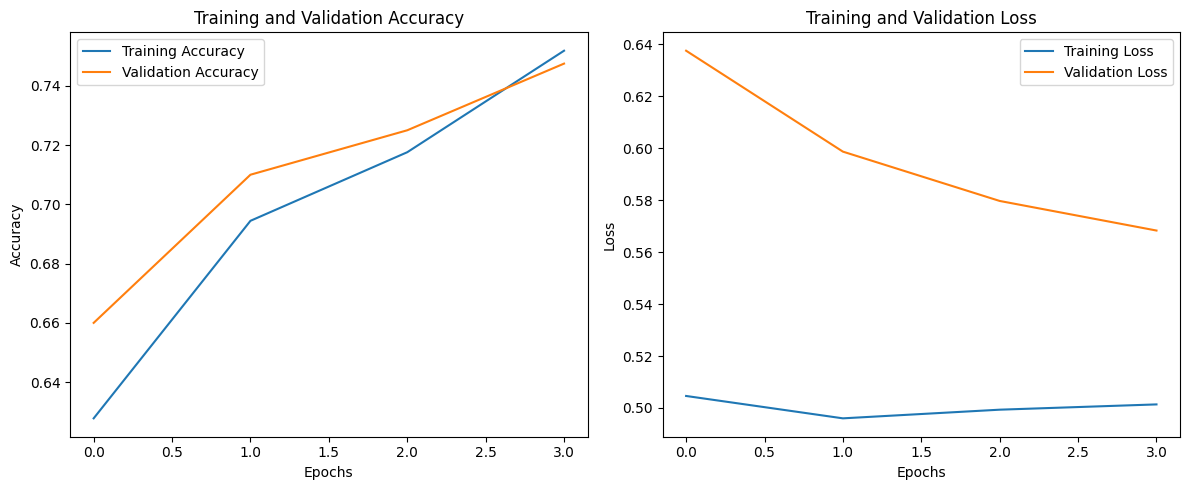

Training with random seed: 150
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.5560 - auc: 0.5550 - loss: 0.5723 - val_accuracy: 0.5525 - val_auc: 0.5665 - val_loss: 0.6899
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5704 - auc: 0.5690 - loss: 0.5213 - val_accuracy: 0.6250 - val_auc: 0.6466 - val_loss: 0.6661
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6702 - auc: 0.6918 - loss: 0.5112 - val_accuracy: 0.6800 - val_auc: 0.7283 - val_loss: 0.6185
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7102 - auc: 0.7631 - loss: 0.4883 - val_accuracy: 0.7075 - val_auc: 0.7566 - val_loss: 0.5945
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5239 - auc: 0.5442 - loss: 0.6957
Test Loss: 0.689896821975708
Test Accuracy: 0.5525000095367432
Test AUC: 0.5664656758308411


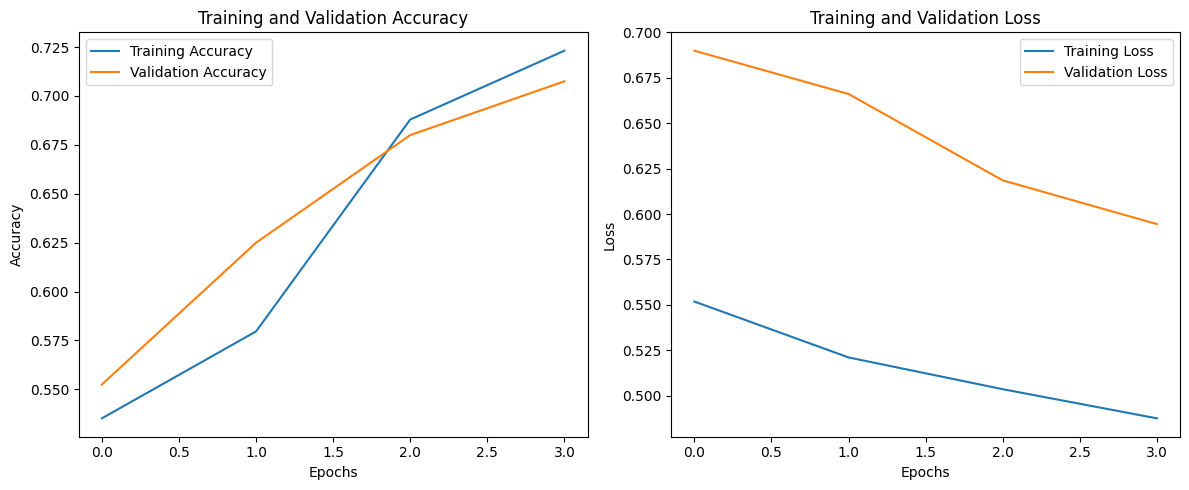

Training with random seed: 160
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.5429 - auc: 0.5863 - loss: 0.4238 - val_accuracy: 0.6425 - val_auc: 0.6802 - val_loss: 0.6472
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6560 - auc: 0.7070 - loss: 0.4824 - val_accuracy: 0.5650 - val_auc: 0.5650 - val_loss: 0.6883
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5287 - auc: 0.5158 - loss: 0.5037 - val_accuracy: 0.5650 - val_auc: 0.5650 - val_loss: 0.6847
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5287 - auc: 0.5132 - loss: 0.5001 - val_accuracy: 0.5650 - val_auc: 0.5650 - val_loss: 0.6847
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6193 - auc: 0.6604 - loss: 0.6562
Test Loss: 0.6472271680831909
Test Accuracy: 0.6424999833106995
Test AUC: 0.6802375316619873


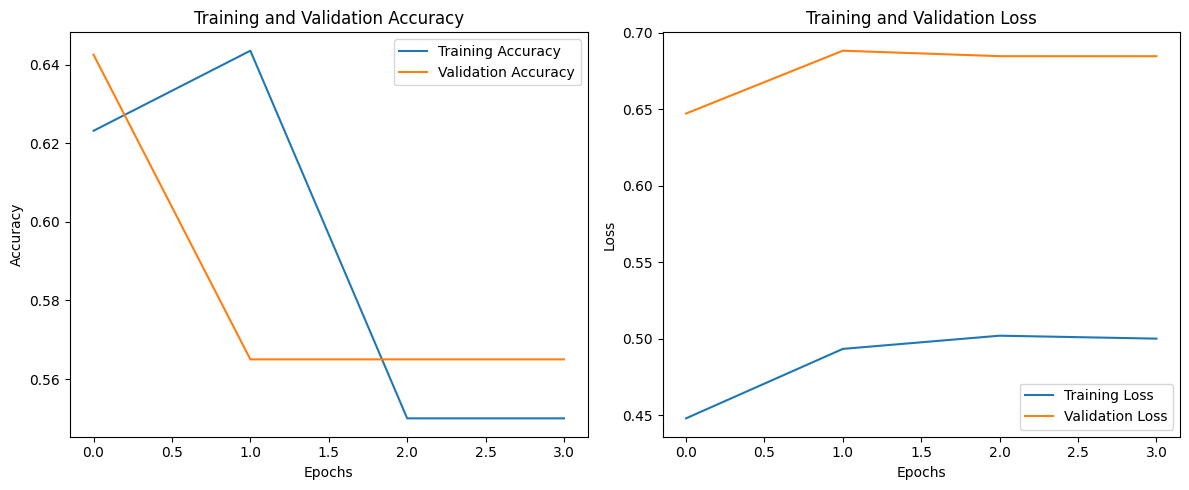

Training with random seed: 170
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.5501 - auc: 0.5487 - loss: 0.5418 - val_accuracy: 0.5650 - val_auc: 0.5605 - val_loss: 0.6917
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.5612 - auc: 0.5728 - loss: 0.5109 - val_accuracy: 0.6075 - val_auc: 0.6269 - val_loss: 0.6629
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6474 - auc: 0.6880 - loss: 0.4946 - val_accuracy: 0.6525 - val_auc: 0.7198 - val_loss: 0.6295
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6887 - auc: 0.7350 - loss: 0.5017 - val_accuracy: 0.6925 - val_auc: 0.7644 - val_loss: 0.6043
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5305 - auc: 0.5314 - loss: 0.7044
Test Loss: 0.6916986703872681
Test Accuracy: 0.5649999976158142
Test AUC: 0.5604969263076782


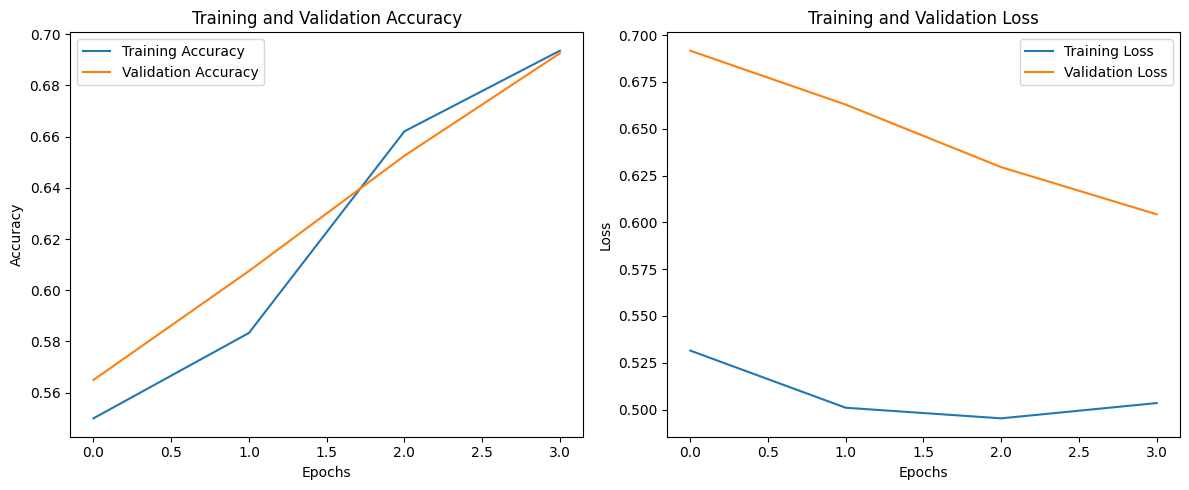

Training with random seed: 180
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.4897 - auc: 0.5121 - loss: 0.5286 - val_accuracy: 0.5800 - val_auc: 0.5711 - val_loss: 0.6879
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5584 - auc: 0.5668 - loss: 0.5106 - val_accuracy: 0.6150 - val_auc: 0.6331 - val_loss: 0.6674
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6587 - auc: 0.6600 - loss: 0.5078 - val_accuracy: 0.6475 - val_auc: 0.6658 - val_loss: 0.6490
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6712 - auc: 0.6807 - loss: 0.5011 - val_accuracy: 0.6650 - val_auc: 0.6901 - val_loss: 0.6338
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5551 - auc: 0.5454 - loss: 0.6970
Test Loss: 0.687926709651947
Test Accuracy: 0.5799999833106995
Test AUC: 0.5711280703544617


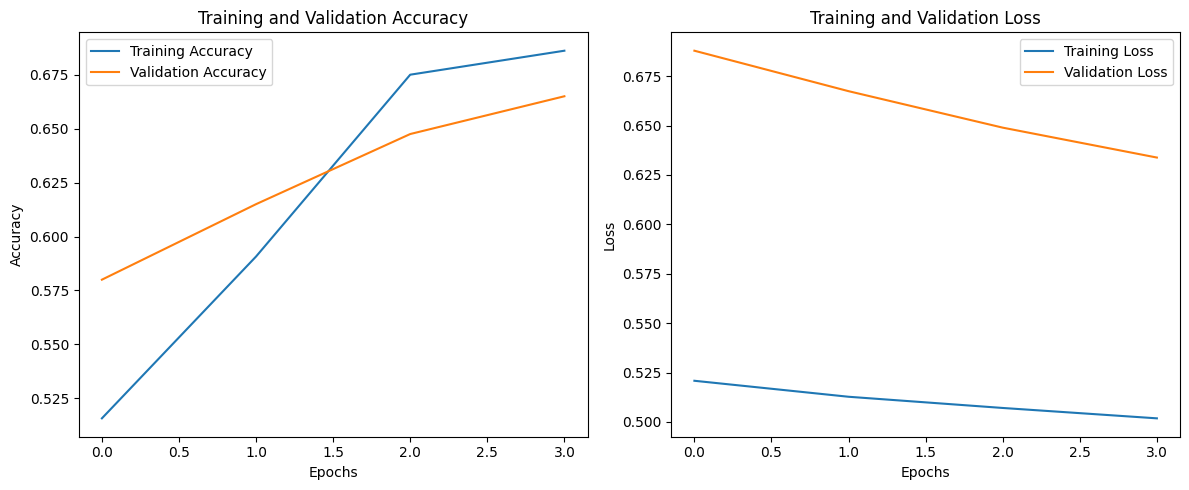

Training with random seed: 190
Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.5496 - auc: 0.5467 - loss: 0.5937 - val_accuracy: 0.6150 - val_auc: 0.6161 - val_loss: 0.6734
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6398 - auc: 0.6691 - loss: 0.5137 - val_accuracy: 0.6375 - val_auc: 0.6811 - val_loss: 0.6457
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6624 - auc: 0.7172 - loss: 0.5108 - val_accuracy: 0.6725 - val_auc: 0.7115 - val_loss: 0.6283
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6750 - auc: 0.7491 - loss: 0.5124 - val_accuracy: 0.6625 - val_auc: 0.7164 - val_loss: 0.6211
Testing Process
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6005 - auc: 0.5987 - loss: 0.6813
Test Loss: 0.6733607649803162
Test Accuracy: 0.6150000095367432
Test AUC: 0.6161344051361084


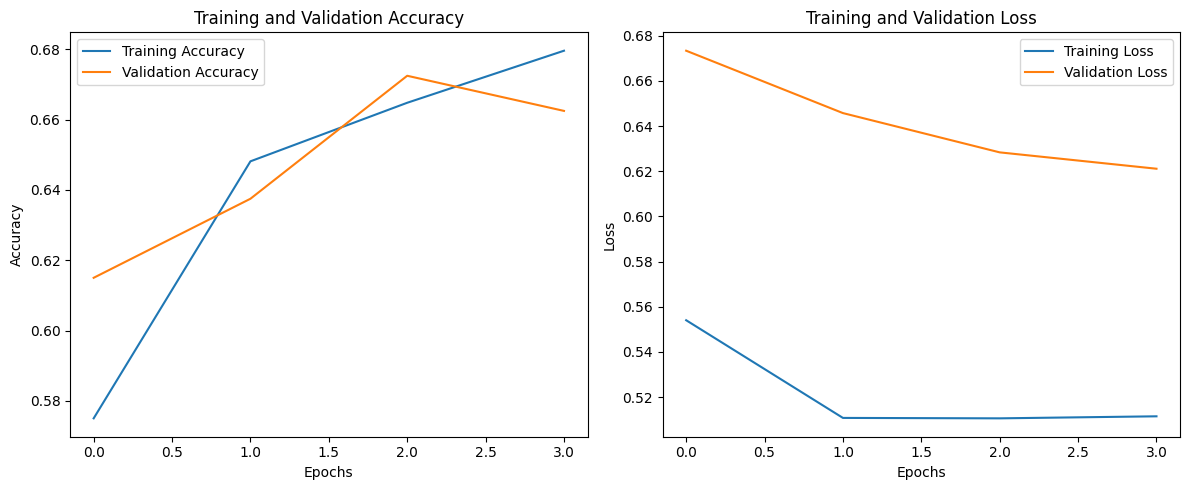

In [25]:
accuracy = []
auc = []
for random in range(10,200,10):
    rd.seed(random)
    np.random.seed(random)
    tf.random.set_seed(random)
    qml.numpy.random.seed(random)
    print('Training with random seed:', random)
    model = HybridModel(random)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',   # Metric to monitor
        patience=3,           # Number of epochs with no improvement after which training will be stopped
        min_delta=0.01,      # Minimum change to qualify as an improvement
        restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
    )
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy','auc'])
    
    # Train the model and store the validation accuracy
    history = model.fit(
        train_images, train_labels,
        epochs=20,
        batch_size=2,
        validation_data=(test_images, test_labels),
        verbose=1,
        callbacks=[early_stopping, StepCallback()]  # Include the EarlyStopping callback
    )

    print('Testing Process')
    test_loss, test_accuracy , test_auc = model.evaluate(test_images, test_labels)
    accuracy.append(test_accuracy)
    auc.append(test_auc)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test AUC: {test_auc}")

    plot_learning_curve(history)


# Benchmark table 


**!0 Times** 

Mean accuracy for Retina MNIST: 0.6597 ± 0.0541


Mean AUC for Retina MNIST: 0.6957 ± 0.0630




In [26]:
mean_acc_retina_mnist = np.mean(accuracy)
std_acc_retina_mnist = np.std(accuracy)
mean_auc_retina_mnist = np.mean(auc)
std_auc_retina_mnist = np.std(auc)

print(f"Mean accuracy for Retina MNIST: {mean_acc_retina_mnist:.4f} ± {std_acc_retina_mnist:.4f}")
print(f"Mean AUC for Retina MNIST: {mean_auc_retina_mnist:.4f} ± {std_auc_retina_mnist:.4f}")

Mean accuracy for Retina MNIST: 0.6143 ± 0.0710
Mean AUC for Retina MNIST: 0.6361 ± 0.0879
